In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jax.example_libraries.optimizers import adam as optimizer
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_disable_jit', True)

In [2]:
MB = 128
NN_SHAPES = jnp.array([64, 64])
SCALE = 1
INIT_KEYS = jax.random.split(jax.random.PRNGKey(1), 6)

OBJECTIVE_FN = lambda x: jnp.log(x) + 10 * jnp.int32(x > 0.5)

In [3]:
w0 = SCALE * jax.random.normal(INIT_KEYS[0], shape=(1, NN_SHAPES[0]))
w1 = SCALE * jax.random.normal(INIT_KEYS[1], shape=(NN_SHAPES[0], NN_SHAPES[1]))
wf = SCALE * jax.random.normal(INIT_KEYS[2], shape=(NN_SHAPES[1], 1))
b0 = SCALE * jax.random.normal(INIT_KEYS[3], shape=(1, NN_SHAPES[0]))
b1 = SCALE * jax.random.normal(INIT_KEYS[4], shape=(1, NN_SHAPES[1]))
bf = SCALE * jax.random.normal(INIT_KEYS[5], shape=(1, 1))
params0 = {'w0': w0, 'w1': w1, 'wf': wf, 'b0': b0, 'b1': b1, 'bf': bf}

In [4]:
@jax.jit
def linear(X, w, b):
    return jnp.dot(X, w) + b


@jax.jit
def relu(X, w, b):
    return jnp.maximum(linear(X, w, b), 0)


@jax.jit
def neural_network(params, x):
    l0 = jnp.squeeze(x)
    l1 = relu(l0, params['w0'], params['b0'])
    l2 = relu(l1, params['w1'], params['b1'])
    return linear(l2, params['wf'], params['bf'])


@jax.jit
def loss(params, x):
    return neural_network(params, x) - OBJECTIVE_FN(x)


@jax.jit
def batch_loss(params, xs):
    losses = jax.vmap(loss, in_axes=(None, 0))(params, xs)
    return jnp.mean(losses**2)

In [5]:
def training_loop(X, opt_state, opt_update, get_params, max_iter=1000):
    j = 0
    key = jax.random.PRNGKey(1)

    while j < max_iter:
        sample = jax.random.choice(key, jnp.arange(X.shape[0]), (MB,))
        key, subkey = jax.random.split(key)

        val_loss, grad = jax.value_and_grad(batch_loss)(get_params(opt_state), X[sample])
        opt_state = opt_update(j, grad, opt_state)
        j += 1
        if j % 100 == 0:
            print(f'Iteration: {j}\tLoss: {val_loss}')
            
    return opt_state

In [12]:
opt_init, opt_update, get_params = optimizer(step_size=1e-1)
opt_state = opt_init(params0)
X = jnp.linspace(1e-5, 1., 5000)

opt_state = training_loop(X, opt_state, opt_update, get_params, max_iter=5000)

Iteration: 100	Loss: 4.187056541442871
Iteration: 200	Loss: 3.5424790382385254
Iteration: 300	Loss: 2.7195727825164795
Iteration: 400	Loss: 2.315171957015991
Iteration: 500	Loss: 1.7131783962249756
Iteration: 600	Loss: 1.5762064456939697
Iteration: 700	Loss: 1.9286627769470215
Iteration: 800	Loss: 1.5087236166000366
Iteration: 900	Loss: 1.0112388134002686
Iteration: 1000	Loss: 1.3023271560668945
Iteration: 1100	Loss: 1.4391716718673706
Iteration: 1200	Loss: 0.8888248205184937
Iteration: 1300	Loss: 0.7068401575088501
Iteration: 1400	Loss: 1.0028036832809448
Iteration: 1500	Loss: 0.9239494800567627
Iteration: 1600	Loss: 0.33960363268852234
Iteration: 1700	Loss: 0.9841512441635132
Iteration: 1800	Loss: 0.4569493532180786
Iteration: 1900	Loss: 0.7587043642997742
Iteration: 2000	Loss: 0.6019670963287354
Iteration: 2100	Loss: 0.5996900796890259
Iteration: 2200	Loss: 0.47645580768585205
Iteration: 2300	Loss: 0.44800886511802673
Iteration: 2400	Loss: 0.42250555753707886
Iteration: 2500	Loss: 0

<AxesSubplot:xlabel='0'>

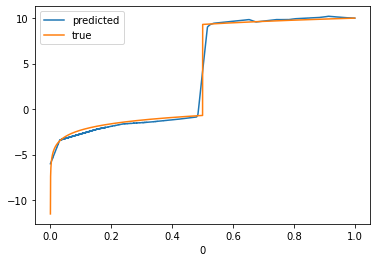

In [13]:
params = get_params(opt_state)
init = jax.vmap(neural_network, in_axes=(None, 0))(params0, X)
pred = jax.vmap(neural_network, in_axes=(None, 0))(params, X)
true = jax.vmap(OBJECTIVE_FN)(X)
df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), init.reshape(-1, 1), pred.reshape(-1, 1), true.reshape(-1, 1)), axis=1)).set_index(0)
df.columns = ['initial', 'predicted', 'true']
df.plot(y=['predicted', 'true'])